# Molecule analysis and visualization

This notebook shows the definition of some functions related to reading, analyzing, and visualizing an coordinates from a molecular XYZ or pdb file.

We will be moving the functions in this notebook to a Python package. We will also discuss how to make your code more readable and user-friendly. Please familiarize yourself with the functions, but please do not focus too much on understanding how everything is working.

**Do not make edits to the code in the first cell - it is important that we all start from the same place for the workshop.**

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from joblib import Memory

location = './cache'
memory = Memory(location, verbose=0)

from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

def calculate_distance(rA, rB):
    # This function calculates the distance between two points given as numpy arrays.
    d=(rA-rB)
    dist=np.linalg.norm(d)
    return dist

def open_pdb(f_loc):
    # This function reads in a pdb file and returns the atom names and coordinates.
    with open(f_loc) as f:
        data = f.readlines()
    c = []
    sym = []
    for line in data:
        if 'ATOM' in l[0:6] or 'HETATM' in line[0:6]:
            sym.append(line[76:79].strip())
            c2 = [float(x) for x in l[30:55].split()]
            c.append(c2)
    coords = np.array(c)
    return sym, coords

atomic_weights = {
    'H': 1.00784,
    'C': 12.0107,
    'N': 14.0067,
    'O': 15.999,
    'P': 30.973762,
    'F': 18.998403,
    'Cl': 35.453,
    'Br': 79.904,
}


def open_xyz(file_location):
    
    # Open an xyz file and return symbols and coordinates.
    xyz_file = np.genfromtxt(fname=file_location, skip_header=2, dtype='unicode')
    symbols = xyz_file[:,0]
    coords = (xyz_file[:,1:])
    coords = coords.astype(np.float)
    return symbols, coords

def write_xyz(file_location, symbols, coordinates):
    
    # Write an xyz file given a file location, symbols, and coordinates.
    num_atoms = len(symbols)
    
    with open(file_location, 'w+') as f:
        f.write('{}\n'.format(num_atoms))
        f.write('XYZ file\n')
        
        for i in range(num_atoms):
            f.write('{}\t{}\t{}\t{}\n'.format(symbols[i], 
                                              coordinates[i,0], coordinates[i,1], coordinates[i,2]))

def draw_molecule(coordinates, symbols, draw_bonds=None, save_location=None, dpi=300):
    
    # Draw a picture of a molecule using matplotlib.
    
    # Create figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Get colors - based on atom name
    colors = []
    for atom in symbols:
        colors.append(atom_colors[atom])
    
    size = np.array(plt.rcParams['lines.markersize'] ** 2)*200/(len(coordinates))

    ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2], marker="o",
               edgecolors='k', facecolors=colors, alpha=1, s=size)
    
    # Draw bonds
    if draw_bonds:
        for atoms, bond_length in draw_bonds.items():
            atom1 = atoms[0]
            atom2 = atoms[1]
            
            ax.plot(coordinates[[atom1,atom2], 0], coordinates[[atom1,atom2], 1],
                    coordinates[[atom1,atom2], 2], color='k')
    
    # Save figure
    if save_location:
        plt.savefig(save_location, dpi=dpi, graph_min=0, graph_max=2)
    
    return ax

def calculate_angle(rA, rB, rC, degrees=False):
    # Calculate the angle between three points. Answer is given in radians by default, but can be given in degrees
    # by setting degrees=True
    AB = rB - rA
    BC = rB - rC
    theta=np.arccos(np.dot(AB, BC)/(np.linalg.norm(AB)*np.linalg.norm(BC)))

    if degrees:
        return np.degrees(theta)
    else:
        return theta

def bond_histogram(bond_list, save_location=None, dpi=300, graph_min=0, graph_max=2):
    # Draw a histogram of bond lengths based on a bond_list (output from build_bond_list function)
    
    
    lengths = []
    for atoms, bond_length in bond_list.items():
        lengths.append(bond_length)
    
    bins = np.linspace(graph_min, graph_max)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    plt.xlabel('Bond Length (angstrom)')
    plt.ylabel('Number of Bonds')
    
    
    ax.hist(lengths, bins=bins)
    
    # Save figure
    if save_location:
        plt.savefig(save_location, dpi=dpi)
    
    return ax
        
def build_bond_list(coordinates, max_bond=1.5, min_bond=0):
    """Calculate bonds in a molecule base on a distance criteria.
    The pairwise distance between atoms is computed. If it is in the range 
    `min_bond` to `max_bond`, the atoms are counted as bonded.
    
    Parameters
    ----------
    coordinates : np.ndarray
        The coordinates of the atoms.
    max_bond : float (optional)
        The maximum distance for two points to be considered bonded. The default
        is 1.5
    min_bond : float (optional)
        The minimum distance for two points to be considered bonded. The default
        is 0.
    
    Returns
    -------
    bonds : dict
        A dictionary where the keys are tuples of the bonded atom indices, and the
        associated values are the bond length.
    """

    if min_bond < 0:
        raise ValueError("Bond length can not be less than zero.")

    if len(coordinates) < 1:
        raise ValueError("Bond list can not be calculated for coordinate length less than 1.")
    
    # Find the bonds in a molecule
    bonds = {}
    num_atoms = len(coordinates)

    for atom1 in range(num_atoms):
        for atom2 in range(atom1, num_atoms):
            distance = calculate_distance(coordinates[atom1], coordinates[atom2])
            if distance > min_bond and distance < max_bond:
                bonds[(atom1, atom2)] = distance

    return bonds

atom_colors = {
    'H': 'white',
    'C': '#D3D3D3',
    'N': '#add8e6',
    'O': 'red',
    'P': '#FFA500',
    'F': '#FFFFE0',
    'Cl': '#98FB98',
    'Br': '#F4A460',
    'S': 'yellow'
}

@memory.cache
def calculate_molecular_mass(symbols):
    """Calculate the mass of a molecule.
    
    Parameters
    ----------
    symbols : list
        A list of elements.
    
    Returns
    -------
    mass : float
        The mass of the molecule
    """
    
    print("Calculating molecular mass")

    mass = 0
    for atom in symbols:
        mass += atomic_weights[atom]
    
    return mass

# Using the atomic_weights dictionary, write a function which calculates the center of mass of a molecule.
def calculate_center_of_mass(symbols, coordinates):
    """Calculate the center of mass of a molecule.
    
    The center of mass is weighted by each atom's weight.
    
    Parameters
    ----------
    symbols : list
        A list of elements for the molecule
    coordinates : np.ndarray
        The coordinates of the molecule.
    
    Returns
    -------
    center_of_mass: np.ndarray
        The center of mass of the molecule.
        
    Notes
    -----
    The center of mass is calculated with the formula
    
    .. math:: \\vec{R}=\\frac{1}{M} \\sum_{i=1}^{n} m_{i}\\vec{r_{}i}
    
    """

    total_mass = calculate_molecular_mass(symbols)
    
    mass_array = np.zeros([len(symbols), 1])
    
    for i in range(len(symbols)):
        mass_array[i] = atom_weights[symbols[i]]
    
    center_of_mass = sum(coordinates * mass_array) / total_mass
    
    return center_of_mass



In [3]:
symbols, coordinates = open_xyz('data/xyz/1bna.xyz')

In [4]:
t_start = time.time()
calculate_molecular_mass(symbols)
t_end = time.time()

print(t_end-t_start)

Calculating molecular mass
0.008226156234741211


In [5]:
# Cached
t_start = time.time()
calculate_molecular_mass(symbols)
t_end = time.time()

print(t_end-t_start)

0.003559112548828125


In [6]:
# Demonstrate with something bigger
symbols = ['C', 'H', 'H', 'H', 'C', 'H', 'H', 'H']*100000

In [7]:
t_start = time.time()
calculate_molecular_mass(symbols)
t_end = time.time()

print(t_end-t_start)

Calculating molecular mass
6.909709692001343


/Users/jessica/miniconda3/envs/molssi_best_practices/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Persisting input arguments took 2.31s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  


In [8]:
# Cached
t_start = time.time()
calculate_molecular_mass(symbols)
t_end = time.time()

print(t_end-t_start)

2.3978257179260254


In [9]:
benzene_file_path = os.path.join('data', 'xyz', 'benzene.xyz')
benzene_symbols, benzene_coords = open_xyz(benzene_file_path)
benzene_bonds = build_bond_list(benzene_coords)

In [10]:
# This is a dictionary where the keys are the atom indices, and the value is the length of the bond.
# For example, (0,1): 1.39 means that there is a bond between atom 0 and atom 1 and its length is 1.39.
benzene_bonds

{(0, 1): 1.3946587396205568,
 (0, 5): 1.3946587396205568,
 (0, 6): 1.103,
 (1, 2): 1.395,
 (1, 7): 1.1025543070524915,
 (2, 3): 1.3946587396205568,
 (2, 8): 1.1025543070524915,
 (3, 4): 1.3946587396205568,
 (3, 9): 1.1030000000000002,
 (4, 5): 1.395,
 (4, 10): 1.1025543070524915,
 (5, 11): 1.1025543070524915}

In [11]:
avg_sum = 0

for atoms, bl in benzene_bonds.items():
    avg_sum += bl

avg_bl = avg_sum/len(benzene_bonds)

print('The average bond length is {}'.format(avg_bl))

The average bond length is 1.2487376822243494


<IPython.core.display.Javascript object>


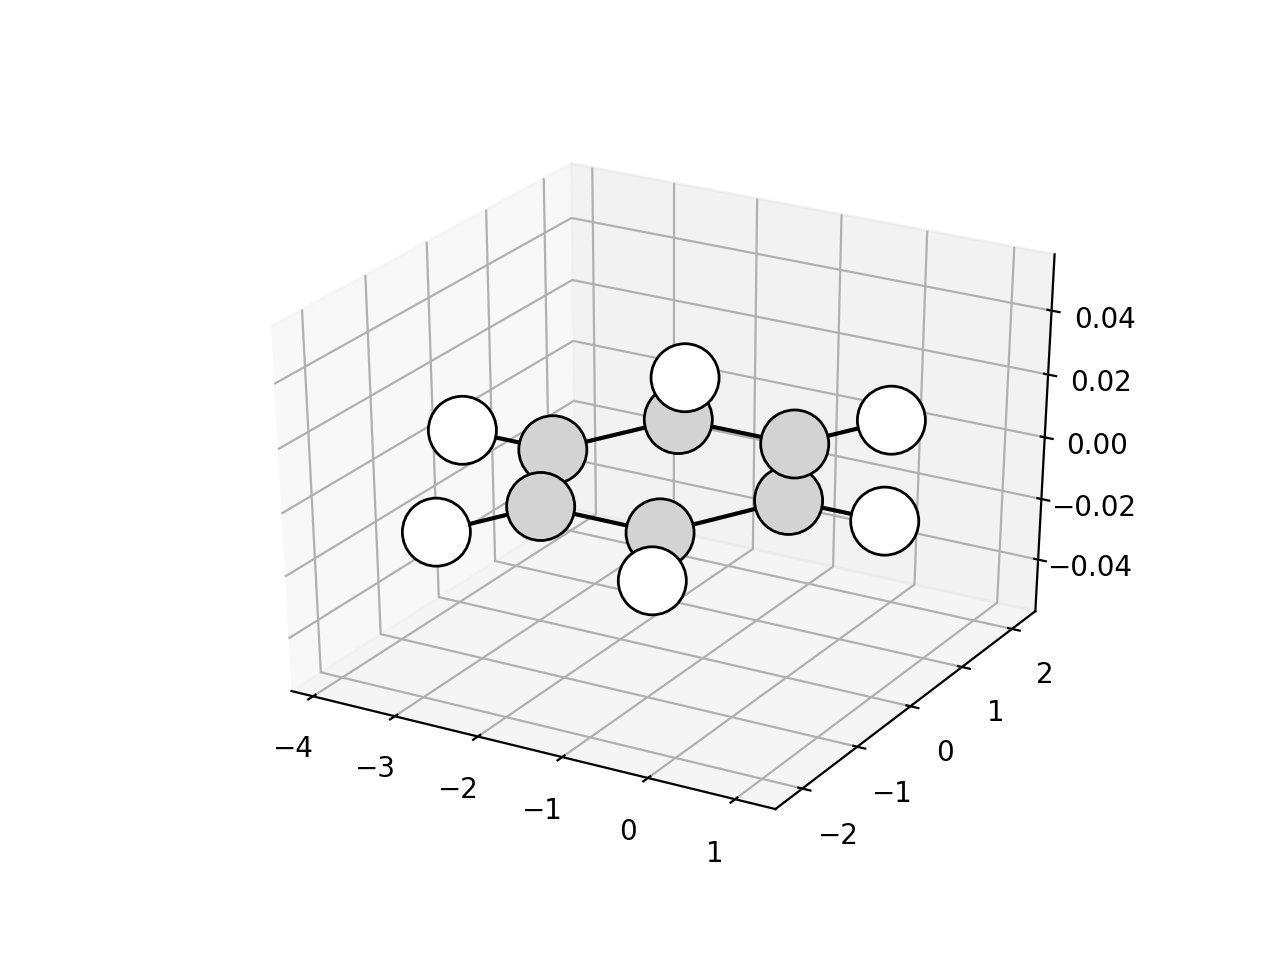

In [12]:
%matplotlib notebook
benzene_fig = draw_molecule(benzene_coords, benzene_symbols, draw_bonds=benzene_bonds)

In [13]:
plt.savefig('benzene.png', dpi=300)

<IPython.core.display.Javascript object>


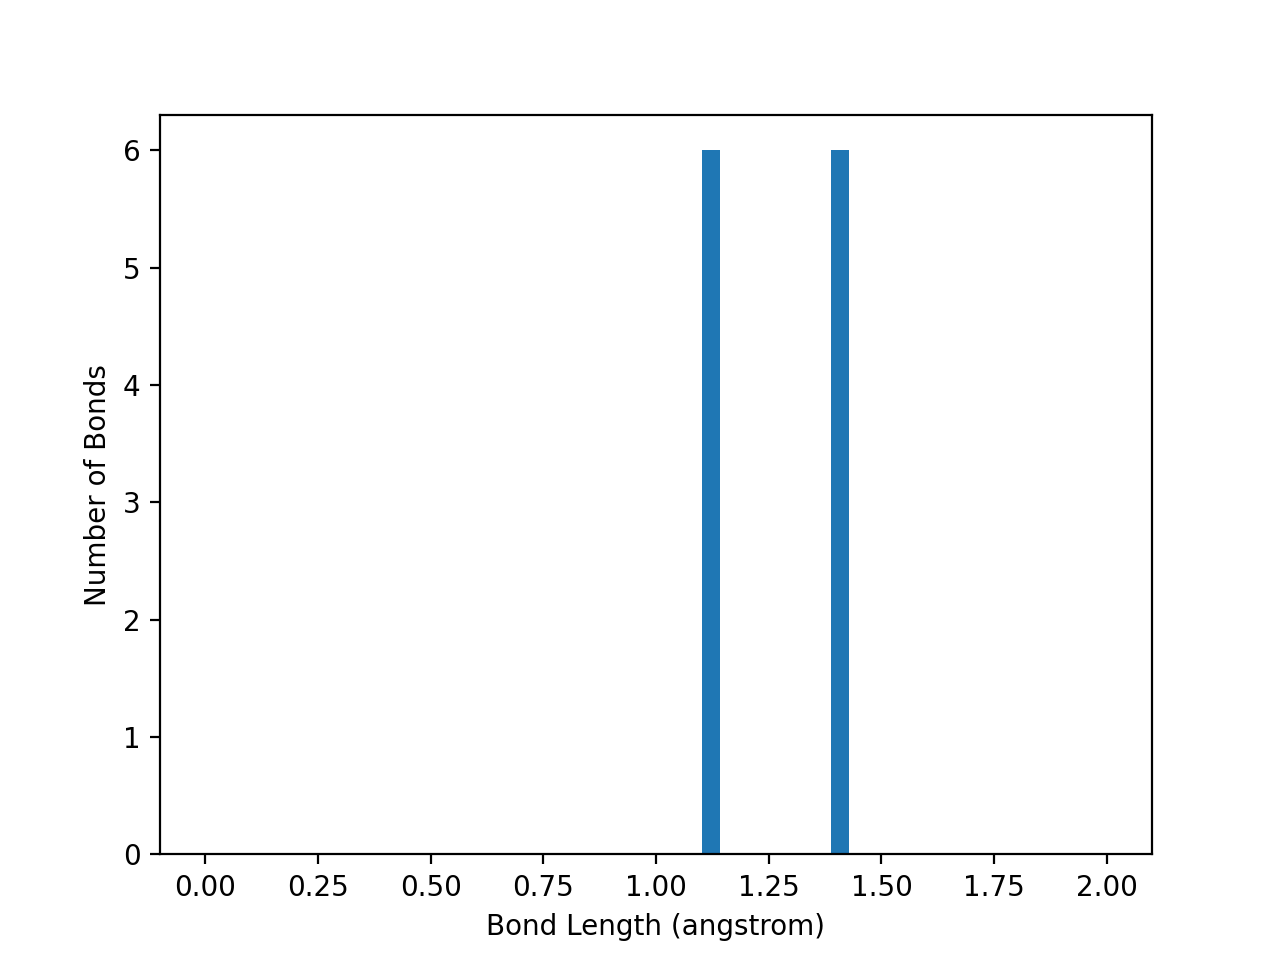

In [14]:
bond_histogram(benzene_bonds, save_location="benzene_histogram.png")